In [1]:
# Import the required libraries
from zipfile import ZipFile
import pandas as pd
import numpy as np
import os
import pickle
import sys  
import plotly.express as px
import plotly.graph_objects as go
import fuzzywuzzy as fw
from fuzzywuzzy import fuzz
import seaborn as sns
import seaborn.objects as so 
import openpyxl
#from functions_cleaning import *
import geopy
from geopy import distance
import statsmodels.formula.api as sm
import plotly.graph_objects as go
from plotnine import *
import matplotlib.pyplot as plt
from statistics import mean
#import functions_empirical_analysis as fea
from linearmodels.iv.absorbing import AbsorbingLS
import matplotlib.pyplot as plt


In [2]:
def data_preparation(data, specifications):
    column_names = specifications["to_categorize"]
    for columnname in column_names:
        data[columnname] = data[columnname].astype("category")
    #interaction terms 
    to_interact = specifications["to_interact"]
    interactions = specifications["interactions"]
    dummylist = []
    for interaction_term in interactions:
        interaction_value = data[interaction_term]
        data = pd.get_dummies(data, columns=[interaction_term], prefix=interaction_term)
        data[interaction_term] = interaction_value
        interaction_dummies = data.columns[data.columns.str.startswith(interaction_term)].tolist()
        interaction_dummies = interaction_dummies[:-1]
        for interaction_dummy in interaction_dummies: 
            for interaction_partner in to_interact: 
                new_string = interaction_dummy + "*" + interaction_partner
                data[new_string] = data[interaction_dummy]*data[interaction_partner]
            dummylist.append(new_string)

    return [data, dummylist]


In [3]:
# Paths for accessing files dynamically
sub_path = os.getcwd()
path_cwd = os.path.dirname(sub_path)
path_dta = os.path.join(path_cwd, "Data_cleaned")
data = pd.DataFrame(pd.read_excel(path_dta + "/dataset_final.xlsx"))

In [4]:
data.columns

Index(['Unnamed: 0', 'organization_location_name', 'advertiser_type_value',
       'advertiser_type_label', 'posting_count', 'date', 'duration',
       'via_intermediary', 'language', 'job_title', 'profession_value',
       'profession_isco_code_value', 'profession_isco_code_label', 'location',
       'location_name', 'region_value', 'region_label',
       'education_level_value', 'education_level_label', 'contract_type_value',
       'contract_type_label', 'working_hours_type_value',
       'working_hours_type_label', 'hours_per_week_from', 'hours_per_week_to',
       'salary', 'organization_industry_value', 'organization_industry_label',
       'organization_size_value', 'organization_size_label',
       'location_coordinates', 'organization_ID', 'log_duration',
       'contract_type_label_cluster', 'salary_dummy',
       'Applicant_language_cluster', 'education_level_cluster',
       'quarter_of_date', 'month_of_date', 'profession_isco_code_value_agg_1',
       'profession_isco_code

# Plots

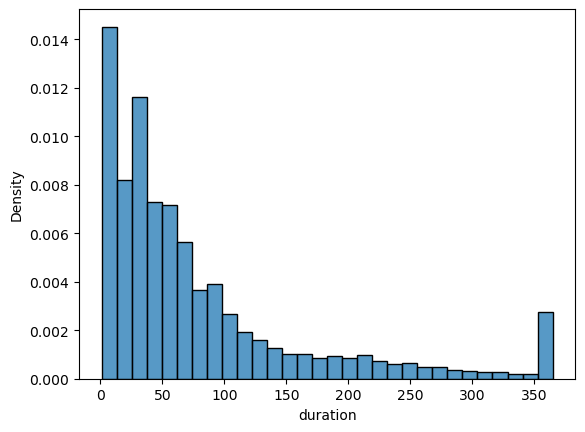

In [5]:
# duration plot 
from IPython.display import display
plot = sns.histplot(data=data, x="duration", bins=30, stat="density")
plt.savefig("duration_cleaned_data.png", format = "png", dpi = 300)
plt.show()

In [6]:
# Interaction plots 



### bin the distances to plot them more easily 
# create bins and labels for the bins
bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]
labels = ['0-100', '101-200', '201-300', '301-400', '401-500', '501-600', '601-700', '701-800', '801-900']

# use the cut function to bin the values and add a new column 'bins' to the dataframe
data['distance_bins'] = pd.cut(data['distance_between_job_and_organization'], bins=bins, labels=labels, include_lowest=True)

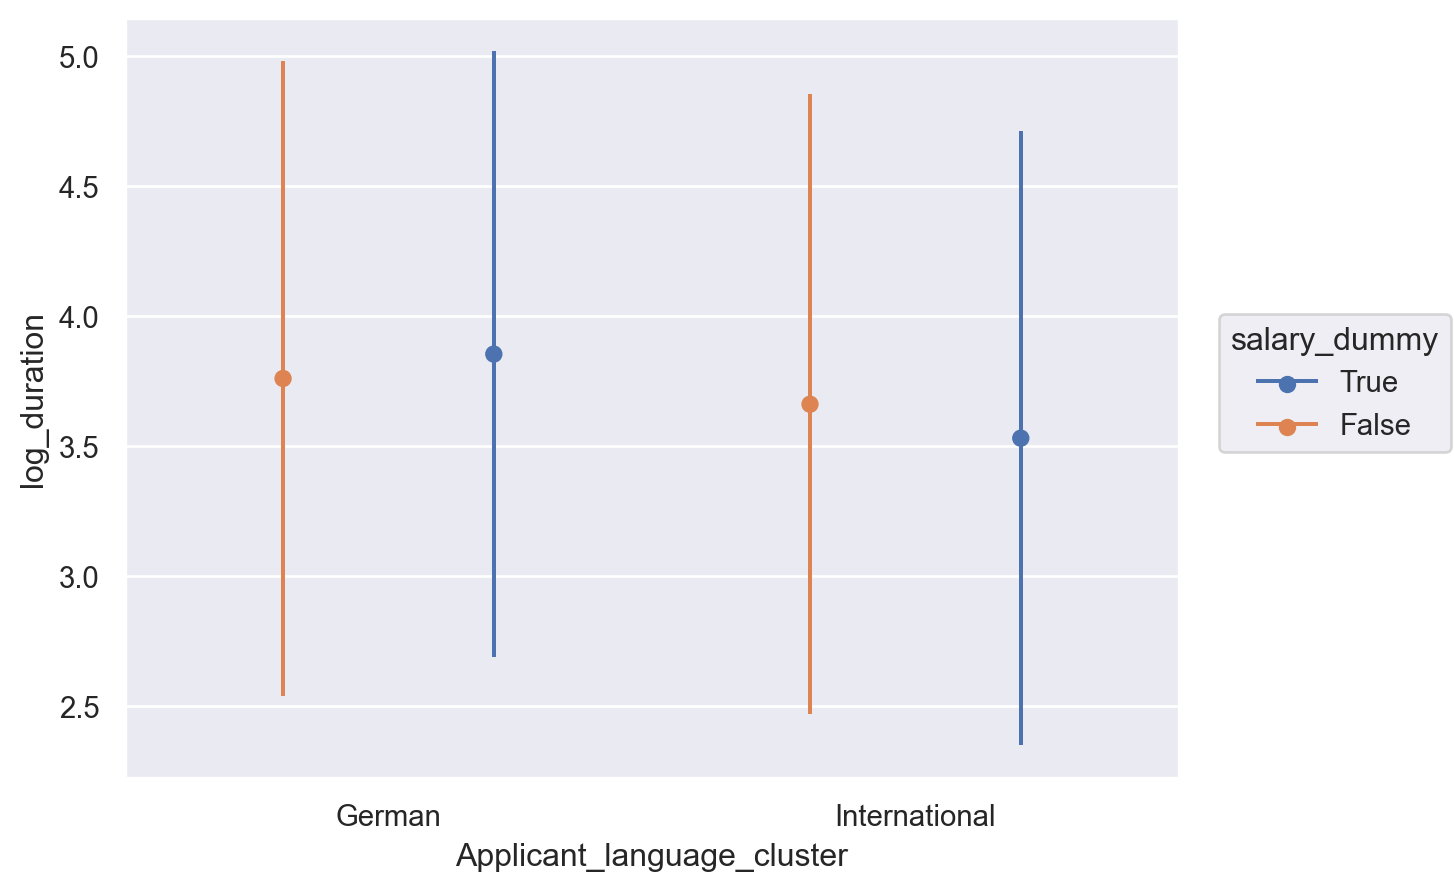

In [7]:
(
    so.Plot(data, x="Applicant_language_cluster", y="log_duration", color="salary_dummy")
    .add(so.Range(), so.Est(errorbar="sd"), so.Dodge())
    .add(so.Dot(), so.Agg(), so.Dodge())
)


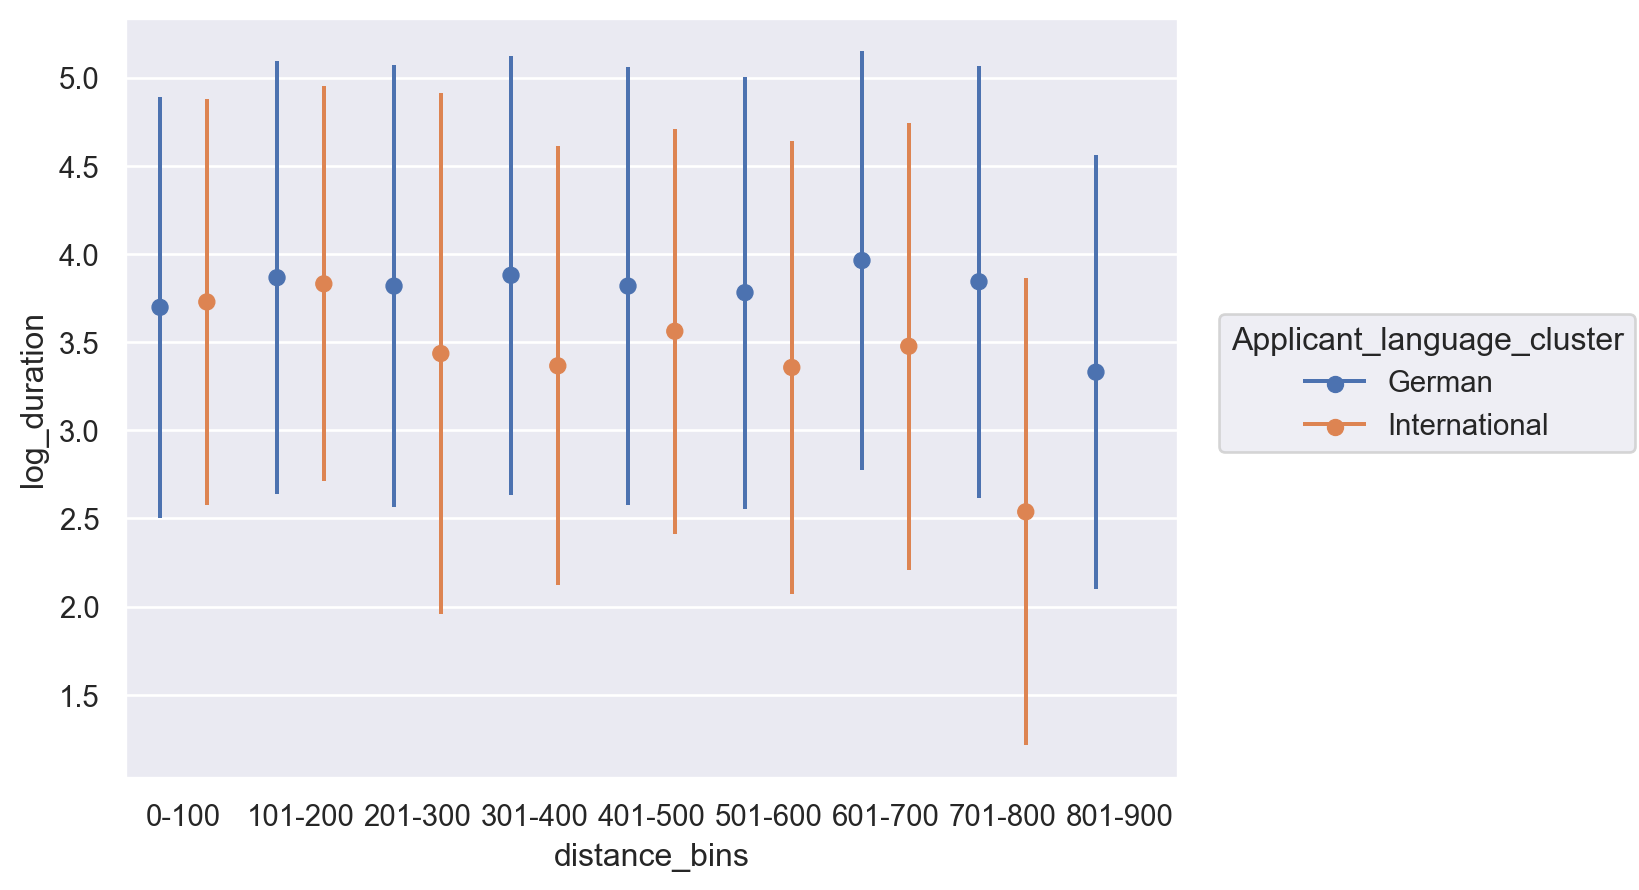

In [8]:
(
    so.Plot(data, x="distance_bins", y="log_duration", color="Applicant_language_cluster")
    .add(so.Range(), so.Est(errorbar="sd"), so.Dodge())
    .add(so.Dot(), so.Agg(), so.Dodge())
)


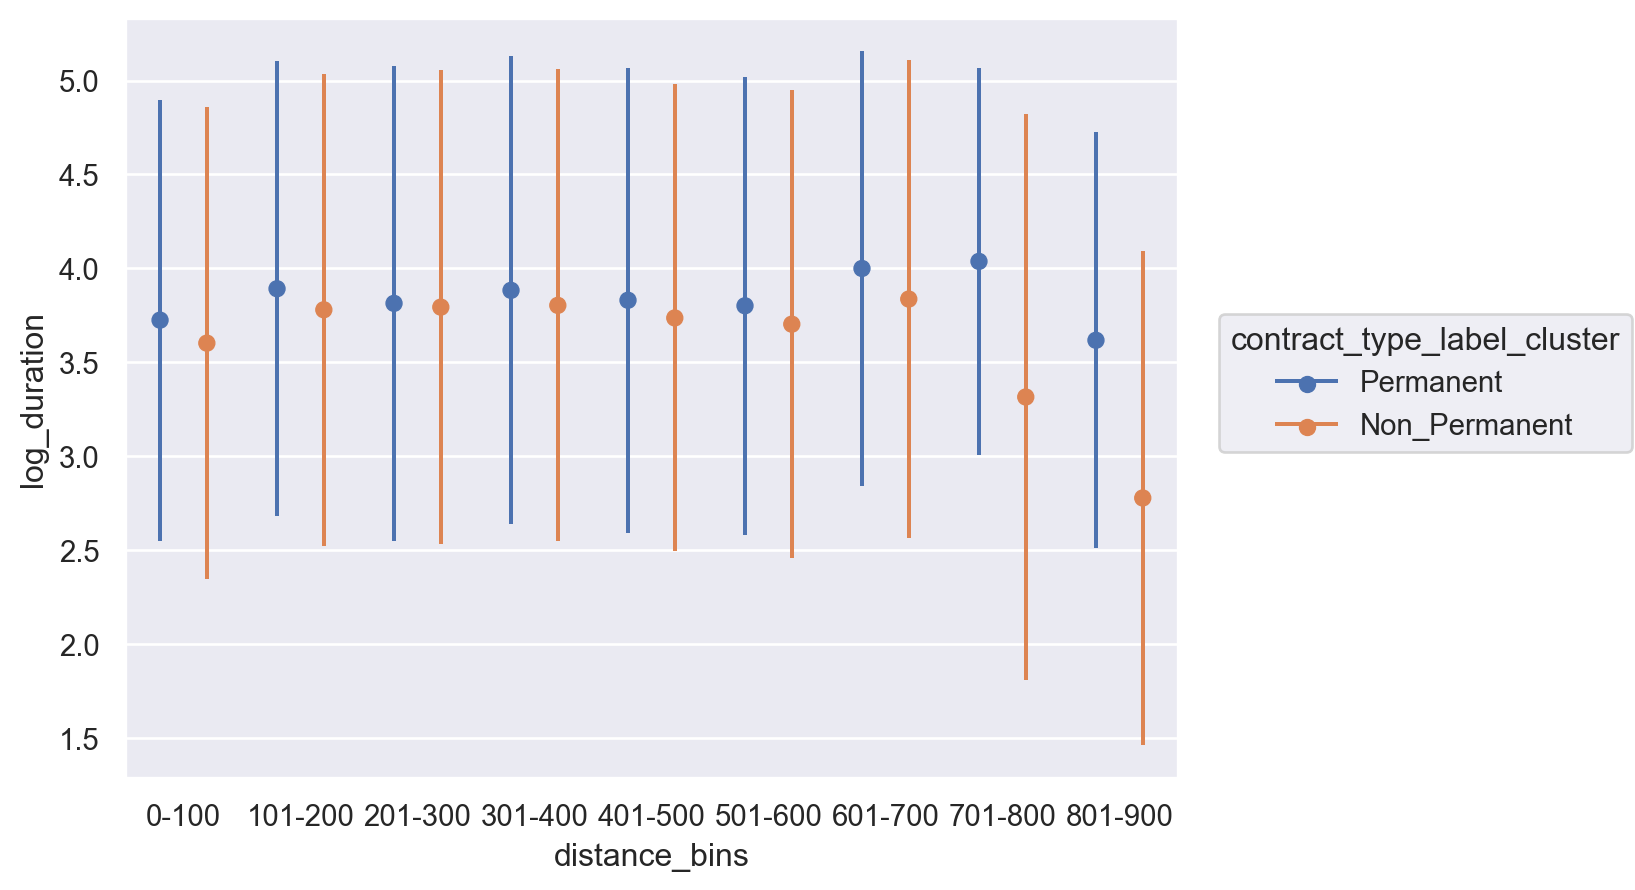

In [9]:
(
    so.Plot(data, x="distance_bins", y="log_duration", color="contract_type_label_cluster")
    .add(so.Range(), so.Est(errorbar="sd"), so.Dodge())
    .add(so.Dot(), so.Agg(), so.Dodge())
)


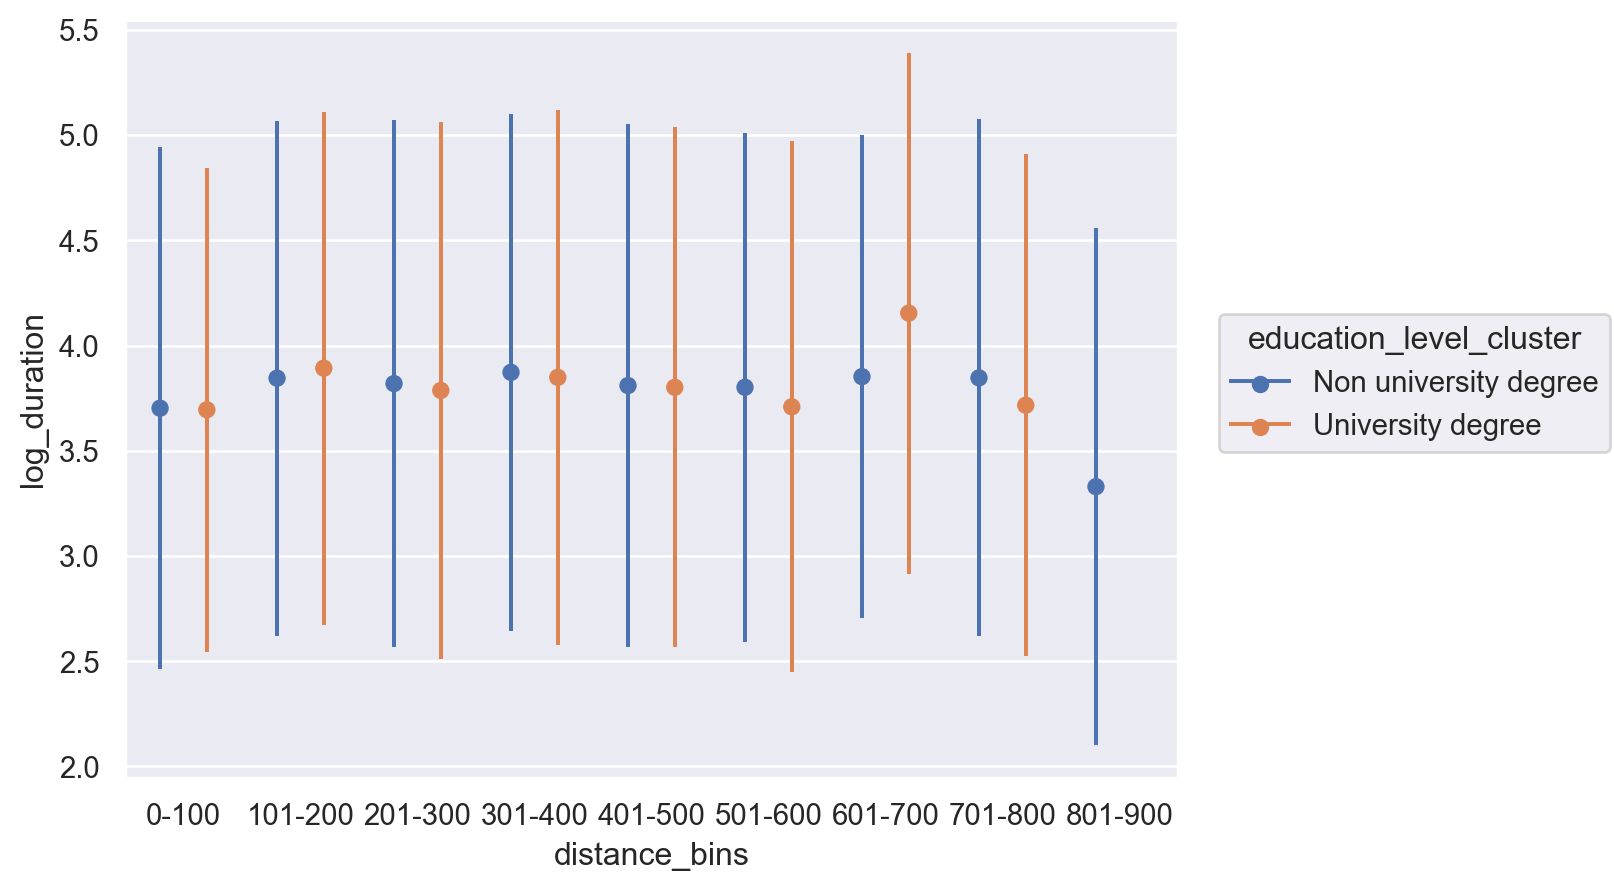

In [10]:
(
    so.Plot(data, x="distance_bins", y="log_duration", color="education_level_cluster")
    .add(so.Range(), so.Est(errorbar="sd"), so.Dodge())
    .add(so.Dot(), so.Agg(), so.Dodge())
)

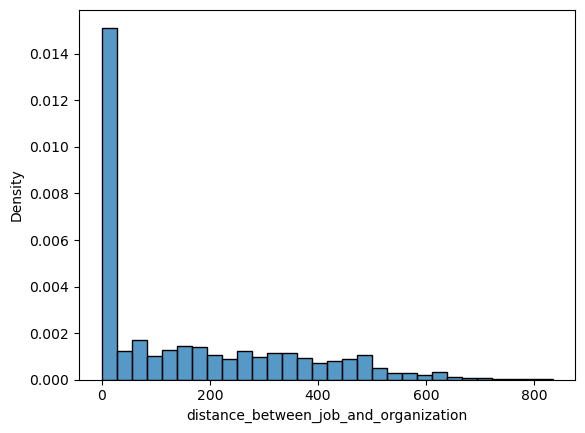

In [11]:
from IPython.display import display
plot = sns.histplot(data=data, x="distance_between_job_and_organization", bins=30, stat="density")
plt.savefig("distance_histogram.png", format = "png", dpi = 300)
plt.show()


In [12]:
# maps plots

import folium
from PIL import Image, ImageDraw
from folium.plugins import FastMarkerCluster

# Create a map of Germany centered around the middle of the country
m = folium.Map(location=[51.0, 9.0], zoom_start=6, tiles='Stamen Toner')

# Add a point for each city in a list of cities
organisation_data = list(zip(data['Latitudal_coordinates_organization'].astype(float), data['Longitudinal_coordinates_organization'].astype(float)))

marker_cluster = FastMarkerCluster(data=organisation_data)
m.add_child(marker_cluster)
m.save('map_hqs.html')


In [13]:
# Create a map of Germany centered around the middle of the country
m = folium.Map(location=[51.0, 9.0], zoom_start=6, tiles='Stamen Toner')

# Add a point for each city in a list of cities
organisation_data = list(zip(data['latitudal_coordinates_job'].astype(float), data['longitudinal_coordinates_job'].astype(float)))
#folium.GeoJson(open("germany.geojson"), name='Germany').add_to(m)

# Add the marker cluster, with the overlay parameter set to True
marker_cluster = FastMarkerCluster(data=organisation_data, overlay=True)
m.add_child(marker_cluster)
m.save('map_jobs_filled.html')

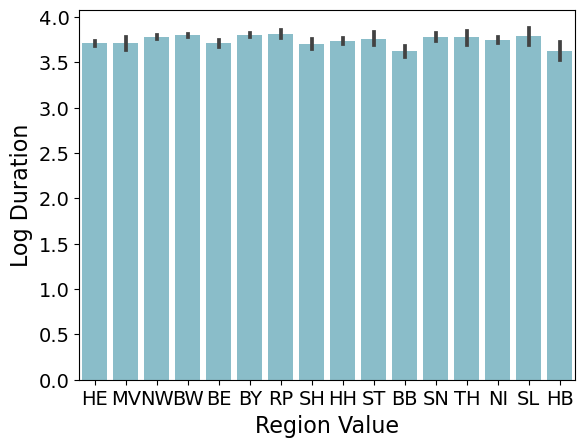

In [14]:
# fixed effects plot 


# plot the mean of the duration variable for each region_value in a color palette from seaborn
barplot_region = sns.barplot(x='region_value', y='log_duration', data=data, color="#7fc4d4")
# increase the font size of the tick labels and axis labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Region Value", fontsize=16)
plt.ylabel("Log Duration", fontsize=16)
plt.savefig("barplot_region.png", format='png', dpi=300)

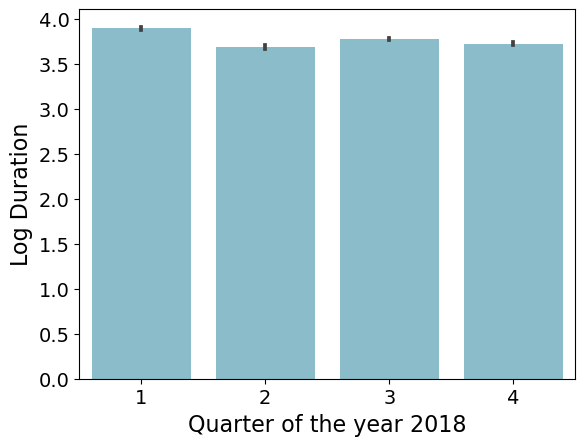

In [15]:
# plot the mean of the duration variable for each region_value in a color palette from seaborn
barplot_date = sns.barplot(x='quarter_of_date', y='log_duration', data=data, color="#7fc4d4")
# increase the font size of the tick labels and axis labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Quarter of the year 2018", fontsize=16)
plt.ylabel("Log Duration", fontsize=16)
plt.savefig("barplot_time.png", format='png', dpi=300)


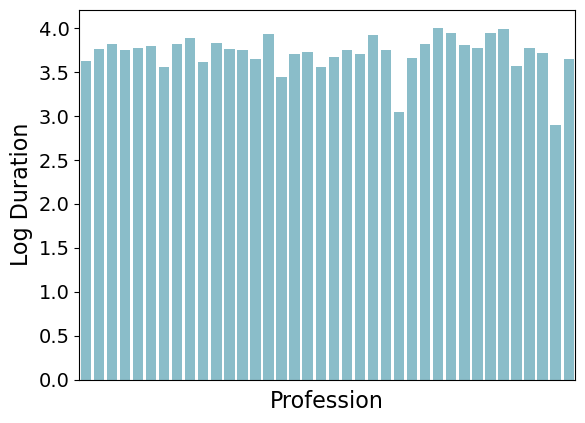

In [16]:

# plot the mean of the duration variable for each region_value in a darker shade of the color "#b9f2f0"
sns.barplot(x='profession_isco_code_value_agg_2', y='log_duration', data=data, color="#7fc4d4", errorbar=None)

# increase the font size of the tick labels and axis labels
plt.xticks([])
plt.yticks(fontsize=14)
plt.xlabel("Profession", fontsize=16)
plt.ylabel("Log Duration", fontsize=16)
plt.savefig("barplot_profession.png", format='png', dpi=300)



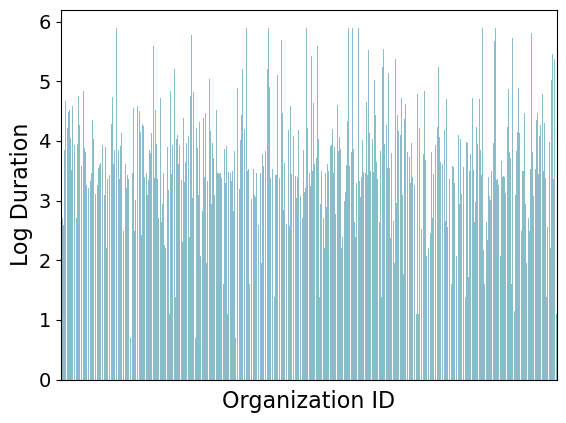

In [17]:

# plot the mean of the duration variable for each region_value in a darker shade of the color "#b9f2f0"
sns.barplot(x='organization_ID', y='log_duration', data=data, color="#7fc4d4", errorbar=None)

# increase the font size of the tick labels and axis labels
plt.xticks([])
plt.yticks(fontsize=14)
plt.xlabel("Organization ID", fontsize=16)
plt.ylabel("Log Duration", fontsize=16)
plt.savefig("barplot_Organization.png", format='png', dpi=300)

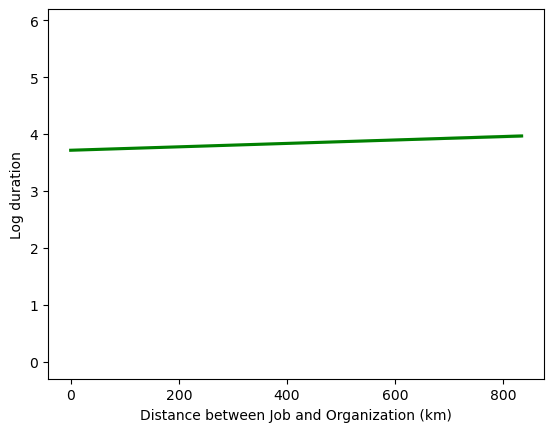

In [18]:
# plain regression plot

fig, ax = plt.subplots()
sns.scatterplot(data=data, x="distance_between_job_and_organization", y="log_duration", alpha = 0, ax=ax)
sns.regplot(data=data, x="distance_between_job_and_organization", y="log_duration", color='green', scatter=False, ax=ax)
ax.set_xlabel("Distance between Job and Organization (km)")
ax.set_ylabel("Log duration")
plt.savefig("basic_regression.png", format='png', dpi=300)
plt.show()


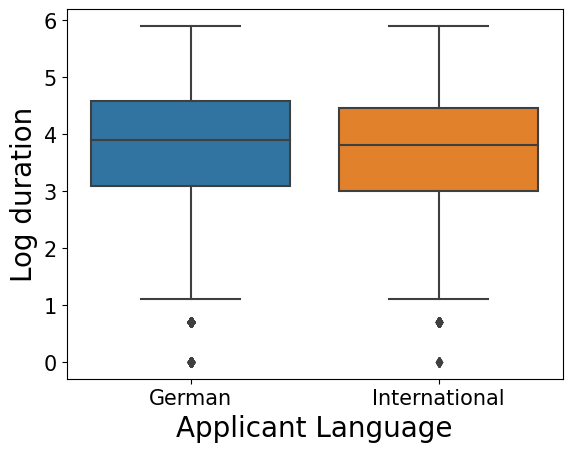

In [19]:
# covariates plot

fig, ax = plt.subplots()
sns.boxplot(x='Applicant_language_cluster', y='log_duration', data=data, ax = ax)
ax.set_xlabel("Applicant Language", fontsize = 20 )
ax.set_ylabel("Log duration", fontsize = 20)
ax.tick_params(axis='both', labelsize=15)
plt.savefig("Boxplot_Applicant_Language.png", format='png', dpi=300)


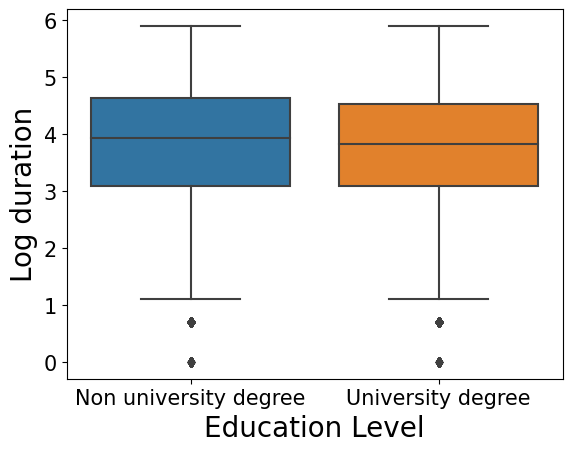

In [20]:
fig, ax = plt.subplots()
sns.boxplot(x='education_level_cluster', y='log_duration', data=data, ax = ax)
ax.set_xlabel("Education Level" ,fontsize = 20)
ax.set_ylabel("Log duration",fontsize = 20)
ax.tick_params(axis='both', labelsize=15)
plt.savefig("Boxplot_Education_Level.png", format='png', dpi=300)


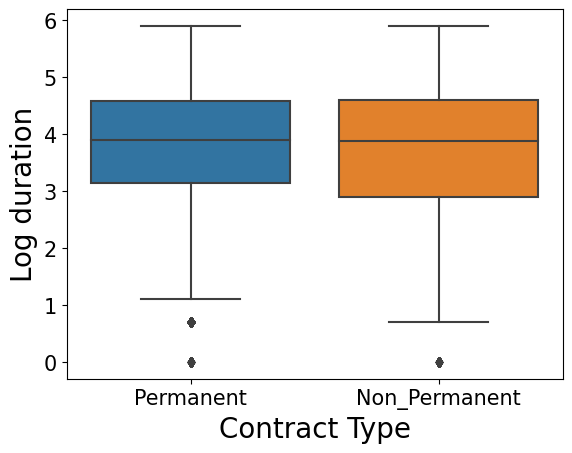

In [21]:
fig, ax = plt.subplots()
sns.boxplot(x='contract_type_label_cluster', y='log_duration', data=data, ax = ax)
ax.set_xlabel("Contract Type",fontsize = 20)
ax.set_ylabel("Log duration",fontsize = 20)
ax.tick_params(axis='both', labelsize=15)
plt.savefig("Boxplot_Contract_Type.png", format='png', dpi=300)


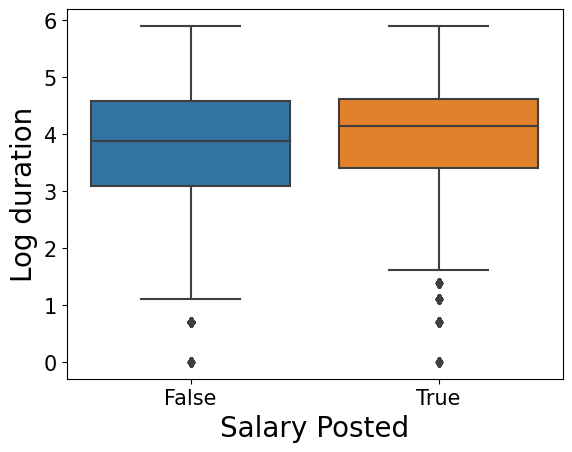

In [22]:
fig, ax = plt.subplots()
sns.boxplot(x='salary_dummy', y='log_duration', data=data, ax = ax)
ax.set_xlabel("Salary Posted", fontsize = 20)
ax.set_ylabel("Log duration", fontsize = 20)
ax.tick_params(axis='both', labelsize=15)
plt.savefig("Boxplot_Salary.png", format='png', dpi=300)

# Table for the numerical explanatory variables

/var/folders/k1/n035yq891w95hzqpmlll09k80000gn/T/ipykernel_58581/688322386.py:6: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`


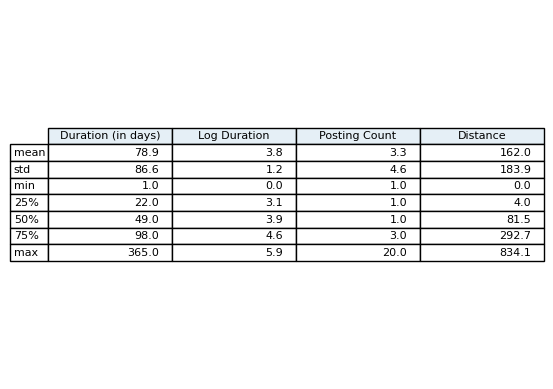

In [23]:
# Select the columns you want to include in the table
columns = [ "duration","log_duration", "posting_count", "distance_between_job_and_organization"]
# Calculate the summary statistics for the selected columns
summary = data[columns].describe().round(1).drop("count")
summary.columns = ["Duration (in days)", "Log Duration", "Posting Count", "Distance"]
summary.style.set_precision(0).set_table_styles([{'selector': 'td, th', 'props': [('text-align', 'center')]}])
column_color =  plt.cm.BuPu(np.full(len(columns), 0.1))
# Create the table
table = plt.table(cellText=summary.values, rowLabels=summary.index, colLabels=summary.columns, 
                 colColours= column_color , loc='center')
#plt.title('Desriptive statistics')
plt.axis('off')
plt.draw()
# Save the table as a .png file
path_dta = os.path.join(path_cwd, "Data_cleaned")
tablepath = os.path.join(path_cwd, "Result_Plots/descriptive_table_1.png")
plt.savefig(tablepath, dpi = 300)

#### Table for the categorical variables

The categorical variables are: 
- Outcome variable: log(duration), Explanatory variable: distance, postings counts, salary posted, education level, contract type, language, language*distance, contract_type*distance education level*distance,  Fixed effects: state FE, month FE, occupation FE, firm FE, 
    - salary posted
    - education level
    - contract type
    - language

In [24]:
def get_category_counts(df, col_name):
    # Get the counts for each category
    counts = df[col_name].value_counts()
    
    # Calculate the relative share for each category
    relative_shares = counts / df.shape[0]
    
    # Create a new dataframe with the category names, the column name, and the relative shares
    result = pd.DataFrame({'Category': counts.index, 'Column': col_name, 'Relative Share': relative_shares})
    
    return result

In [25]:
salary_distr = get_category_counts(df = data, col_name = "salary_dummy")
languag_distr = get_category_counts(df = data, col_name = "Applicant_language_cluster")
educ_distr = get_category_counts(df = data, col_name = "education_level_cluster")
contract_distr = get_category_counts(df = data, col_name = "contract_type_label_cluster")
result = pd.concat([salary_distr, languag_distr,educ_distr , contract_distr], ignore_index=True)


In [26]:
result

,Category,Column,Relative Share
0,False,salary_dummy,0.906966
1,True,salary_dummy,0.093034
2,German,Applicant_language_cluster,0.964891
3,International,Applicant_language_cluster,0.035109
4,Non university degree,education_level_cluster,0.531198
5,University degree,education_level_cluster,0.468802
6,Permanent,contract_type_label_cluster,0.758507
7,Non_Permanent,contract_type_label_cluster,0.241493


# Correlation between postings count and the log duration 

In [27]:
correlation_log_duration_posting_count = data["posting_count"].corr(data["log_duration"])
correlation_duration_posting_count = data["posting_count"].corr(data["duration"])
print(correlation_log_duration_posting_count)
print(correlation_duration_posting_count)

correlation_distance_posting_count = data["posting_count"].corr(data["distance_between_job_and_organization"])
print(correlation_distance_posting_count)


0.22549671685805922
0.1347101151901305
-0.035561357651875375


## Empirical Analysis

#### First Specification: 
- Outcome variable: log(duration), Explanatory variable: distance, postings counts, salary posted, Fixed effects:  firm FE, time FE,
##### Second Specification: 
- Outcome variable: log(duration), Explanatory variable: distance, postings counts, salary posted, education level, contract type, language Fixed effects:month FE, occupation FE, firm FE
#### Third Specification: 
- Outcome variable: log(duration), Explanatory variable: distance, postings counts, salary posted, education level, contract type, language, language*distance, contract_type*distance education level*distance,  Fixed effects: state FE, month FE, occupation FE, firm FE, 

In [28]:
first_specification = {"dependent_variable":"log_duration",
                        "covariates":["distance_between_job_and_organization", "posting_count", "salary_dummy"], 
                        "fixed_effects":["organization_ID", "quarter_of_date"],
                        "to_categorize":["organization_ID", "quarter_of_date","salary_dummy"],
                        "interactions":[],
                        "to_interact":[],
                        "clustering":[]}
second_specification =   {"dependent_variable":"log_duration",
                        "covariates":["distance_between_job_and_organization", "posting_count", "salary_dummy", "education_level_cluster", "contract_type_label_cluster", "Applicant_language_cluster"], 
                        "fixed_effects":["organization_ID", "quarter_of_date","profession_isco_code_value_agg_2"],
                        "to_categorize":["organization_ID", "quarter_of_date","salary_dummy",
                         "Applicant_language_cluster","education_level_value", "contract_type_label_cluster","profession_isco_code_value_agg_2"],
                        "interactions":[],
                        "to_interact":[],
                        "clustering":[]}

third_specification =   {"dependent_variable":"log_duration",
                        "covariates":["distance_between_job_and_organization", "posting_count", "salary_dummy", "education_level_cluster",
                        "contract_type_label_cluster", "Applicant_language_cluster"], 
                        "fixed_effects":["organization_ID", "quarter_of_date","profession_isco_code_value_agg_2", "region_value"],
                        "to_categorize":["organization_ID", "quarter_of_date","salary_dummy","region_value",
                         "Applicant_language_cluster","education_level_value", "contract_type_label_cluster","profession_isco_code_value_agg_2"],
                        "to_interact":["distance_between_job_and_organization"],
                        "interactions":["contract_type_label_cluster", 
                                        "Applicant_language_cluster", 
                                        "education_level_cluster"],
                        "clustering":[]}

In [29]:
interaction_dummy = []
interaction_dummy = data_preparation(data = data, specifications=first_specification)[1]
data = data_preparation(data = data, specifications = first_specification)[0]

In [30]:
print(interaction_dummy)

[]


In [31]:
spec1 = AbsorbingLS(
    data["log_duration"], data[first_specification["covariates"]], absorb=data[first_specification["fixed_effects"]]
)
print(spec1.fit())

                         Absorbing LS Estimation Summary                          
Dep. Variable:           log_duration   R-squared:                          0.2603
Estimator:               Absorbing LS   Adj. R-squared:                     0.2095
No. Observations:               74027   F-statistic:                        6530.2
Date:                Wed, Jan 25 2023   P-value (F-stat):                   0.0000
Time:                        19:19:40   Distribution:                      chi2(3)
Cov. Estimator:                robust   R-squared (No Effects):             0.0628
                                        Varaibles Absorbed:                 4750.0
                                           Parameter Estimates                                           
                                       Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------------------------------
distance_between_j

/opt/homebrew/anaconda3/envs/data_cleaning_applied_micro/lib/python3.10/site-packages/linearmodels/iv/absorbing.py:710: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
/opt/homebrew/anaconda3/envs/data_cleaning_applied_micro/lib/python3.10/site-packages/linearmodels/iv/absorbing.py:711: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.


In [32]:
interaction_dummy = []
interaction_dummy = data_preparation(data = data, specifications=second_specification)[1]
data = data_preparation(data = data, specifications = second_specification)[0]

In [33]:
spec2 = AbsorbingLS(
    data["log_duration"], data[second_specification["covariates"]], absorb=data[second_specification["fixed_effects"]]
)
print(spec2.fit())

/opt/homebrew/anaconda3/envs/data_cleaning_applied_micro/lib/python3.10/site-packages/linearmodels/iv/absorbing.py:710: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
/opt/homebrew/anaconda3/envs/data_cleaning_applied_micro/lib/python3.10/site-packages/linearmodels/iv/absorbing.py:711: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.


                         Absorbing LS Estimation Summary                          
Dep. Variable:           log_duration   R-squared:                          0.2631
Estimator:               Absorbing LS   Adj. R-squared:                     0.2121
No. Observations:               74027   F-statistic:                        6507.0
Date:                Wed, Jan 25 2023   P-value (F-stat):                   0.0000
Time:                        19:19:41   Distribution:                      chi2(6)
Cov. Estimator:                robust   R-squared (No Effects):             0.0632
                                        Varaibles Absorbed:                 4787.0
                                             Parameter Estimates                                             
                                           Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------------------------
distan

In [34]:
interaction_dummy = []
interaction_dummy = data_preparation(data = data, specifications = third_specification)[1]
data_spec_3 = data_preparation(data = data, specifications = third_specification)[0]

In [35]:
for interaction in third_specification["interactions"]:
    for interaction_dummy_value in interaction_dummy:
        if interaction_dummy_value.startswith(interaction):
            interaction_dummy.remove(interaction_dummy_value)
            break
print(interaction_dummy)

['contract_type_label_cluster_Permanent*distance_between_job_and_organization', 'Applicant_language_cluster_International*distance_between_job_and_organization', 'education_level_cluster_University degree*distance_between_job_and_organization']


In [36]:
third_specification['covariates'] += interaction_dummy

In [37]:
spec3 = AbsorbingLS(
    data_spec_3["log_duration"], data_spec_3[third_specification["covariates"]], absorb=data_spec_3[third_specification["fixed_effects"]]
)


/opt/homebrew/anaconda3/envs/data_cleaning_applied_micro/lib/python3.10/site-packages/linearmodels/iv/absorbing.py:710: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
/opt/homebrew/anaconda3/envs/data_cleaning_applied_micro/lib/python3.10/site-packages/linearmodels/iv/absorbing.py:711: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.


In [38]:
print(spec3.fit())

                         Absorbing LS Estimation Summary                          
Dep. Variable:           log_duration   R-squared:                          0.2655
Estimator:               Absorbing LS   Adj. R-squared:                     0.2145
No. Observations:               74027   F-statistic:                        6596.0
Date:                Wed, Jan 25 2023   P-value (F-stat):                   0.0000
Time:                        19:19:42   Distribution:                      chi2(9)
Cov. Estimator:                robust   R-squared (No Effects):             0.0647
                                        Varaibles Absorbed:                 4802.0
                                                                Parameter Estimates                                                                
                                                                                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------

In [39]:
res = spec2.fit()
# Print as latex
print(res.summary.as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                              &   log\_duration    & \textbf{  R-squared:         }     &      0.2631      \\
\textbf{Estimator:}                                  &    Absorbing LS    & \textbf{  Adj. R-squared:    }     &      0.2121      \\
\textbf{No. Observations:}                           &       74027        & \textbf{  F-statistic:       }     &      6507.0      \\
\textbf{Date:}                                       &  Wed, Jan 25 2023  & \textbf{  P-value (F-stat):  }     &      0.0000      \\
\textbf{Time:}                                       &      19:19:42      & \textbf{  Distribution:      }     &     chi2(6)      \\
\textbf{Cov. Estimator:}                             &       robust       & \textbf{  R-squared (No Effects):} &      0.0632      \\
\textbf{}                                            &                    & \textbf{  Varaibles Absorbed:}     &      4793.0      \\
\bottomrule
\end{tabula

### Side specifications: Heterogenous Effects


- Outcome variable: log(duration), Explanatory variable: distance, postings counts, salary posted, education level, contract type, language, language*distance, contract_type*distance education level*distance,  Fixed effects: firm FE 

- Outcome variable: log(duration), Explanatory variable: distance, postings counts, salary posted, education level, contract type, language, language*distance, contract_type*distance education level*distance,  Fixed effects:month FE, firm FE 
- Outcome variable: log(duration), Explanatory variable: distance, postings counts, salary posted, education level, contract type, language, language*distance, contract_type*distance education level*distance,  Fixed effects: state FE, month FE, occupation FE, firm FE, 


In [40]:
first =   {"dependent_variable":"log_duration",
                        "covariates":["distance_between_job_and_organization", "posting_count", "salary_dummy", "education_level_cluster",
                        "contract_type_label_cluster", "Applicant_language_cluster"], 
                        "fixed_effects":["organization_ID"],
                        "to_categorize":["organization_ID","salary_dummy",
                         "Applicant_language_cluster","education_level_value", "contract_type_label_cluster"],
                        "to_interact":["distance_between_job_and_organization"],
                        "interactions":["contract_type_label_cluster", 
                                        "Applicant_language_cluster", 
                                        "education_level_cluster"],
                        "clustering":[]}

second =   {"dependent_variable":"log_duration",
                        "covariates":["distance_between_job_and_organization", "posting_count", "salary_dummy", "education_level_cluster",
                        "contract_type_label_cluster", "Applicant_language_cluster"], 
                        "fixed_effects":["organization_ID", "quarter_of_date"],
                        "to_categorize":["organization_ID", "quarter_of_date","salary_dummy",
                         "Applicant_language_cluster","education_level_value", "contract_type_label_cluster","profession_isco_code_value_agg_2"],
                        "to_interact":["distance_between_job_and_organization"],
                        "interactions":["contract_type_label_cluster", 
                                        "Applicant_language_cluster", 
                                        "education_level_cluster"],
                        "clustering":[]}

third =   {"dependent_variable":"log_duration",
                        "covariates":["distance_between_job_and_organization", "posting_count", "salary_dummy", "education_level_cluster",
                        "contract_type_label_cluster", "Applicant_language_cluster"], 
                        "fixed_effects":["organization_ID", "quarter_of_date","profession_isco_code_value_agg_2", "region_value"],
                        "to_categorize":["organization_ID", "quarter_of_date","salary_dummy", "region_value",
                         "Applicant_language_cluster","education_level_value", "contract_type_label_cluster","profession_isco_code_value_agg_2"],
                        "to_interact":["distance_between_job_and_organization"],
                        "interactions":["contract_type_label_cluster", 
                                        "Applicant_language_cluster", 
                                        "education_level_cluster"],
                        "clustering":[]}

In [41]:
interaction_dummy = []
interaction_dummy = data_preparation(data = data, specifications = first)[1]
data_1 = data_preparation(data = data, specifications = first)[0]

In [42]:
for interaction in third_specification["interactions"]:
    for interaction_dummy_value in interaction_dummy:
        if interaction_dummy_value.startswith(interaction):
            interaction_dummy.remove(interaction_dummy_value)
            break
print(interaction_dummy)

['contract_type_label_cluster_Permanent*distance_between_job_and_organization', 'Applicant_language_cluster_International*distance_between_job_and_organization', 'education_level_cluster_University degree*distance_between_job_and_organization']


In [43]:
first['covariates'] += interaction_dummy

In [44]:
first_model = AbsorbingLS(
    data_1["log_duration"], data_1[first["covariates"]], absorb=data_1[first["fixed_effects"]]
)

/opt/homebrew/anaconda3/envs/data_cleaning_applied_micro/lib/python3.10/site-packages/linearmodels/iv/absorbing.py:710: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
/opt/homebrew/anaconda3/envs/data_cleaning_applied_micro/lib/python3.10/site-packages/linearmodels/iv/absorbing.py:711: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.


In [45]:
print(first_model.fit())

                         Absorbing LS Estimation Summary                          
Dep. Variable:           log_duration   R-squared:                          0.2530
Estimator:               Absorbing LS   Adj. R-squared:                     0.2017
No. Observations:               74027   F-statistic:                        6010.9
Date:                Wed, Jan 25 2023   P-value (F-stat):                   0.0000
Time:                        19:19:43   Distribution:                      chi2(9)
Cov. Estimator:                robust   R-squared (No Effects):             0.0580
                                        Varaibles Absorbed:                 4747.0
                                                                Parameter Estimates                                                                
                                                                                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------

In [46]:
interaction_dummy = []
interaction_dummy = data_preparation(data = data, specifications = second)[1]
data_2 = data_preparation(data = data, specifications = second)[0]

In [47]:
for interaction in third_specification["interactions"]:
    for interaction_dummy_value in interaction_dummy:
        if interaction_dummy_value.startswith(interaction):
            interaction_dummy.remove(interaction_dummy_value)
            break
print(interaction_dummy)

['contract_type_label_cluster_Permanent*distance_between_job_and_organization', 'Applicant_language_cluster_International*distance_between_job_and_organization', 'education_level_cluster_University degree*distance_between_job_and_organization']


In [48]:
second['covariates'] += interaction_dummy

In [49]:
second_model = AbsorbingLS(
    data_2["log_duration"], data_2[second["covariates"]], absorb=data_2[second["fixed_effects"]]
)

/opt/homebrew/anaconda3/envs/data_cleaning_applied_micro/lib/python3.10/site-packages/linearmodels/iv/absorbing.py:710: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
/opt/homebrew/anaconda3/envs/data_cleaning_applied_micro/lib/python3.10/site-packages/linearmodels/iv/absorbing.py:711: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.


In [50]:
print(second_model.fit())

                         Absorbing LS Estimation Summary                          
Dep. Variable:           log_duration   R-squared:                          0.2611
Estimator:               Absorbing LS   Adj. R-squared:                     0.2104
No. Observations:               74027   F-statistic:                        6588.7
Date:                Wed, Jan 25 2023   P-value (F-stat):                   0.0000
Time:                        19:19:44   Distribution:                      chi2(9)
Cov. Estimator:                robust   R-squared (No Effects):             0.0639
                                        Varaibles Absorbed:                 4750.0
                                                                Parameter Estimates                                                                
                                                                                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------

In [51]:
interaction_dummy = []
interaction_dummy = data_preparation(data = data, specifications = third)[1]
data_3 = data_preparation(data = data, specifications = third)[0]

In [52]:
for interaction in third_specification["interactions"]:
    for interaction_dummy_value in interaction_dummy:
        if interaction_dummy_value.startswith(interaction):
            interaction_dummy.remove(interaction_dummy_value)
            break
print(interaction_dummy)

['contract_type_label_cluster_Permanent*distance_between_job_and_organization', 'Applicant_language_cluster_International*distance_between_job_and_organization', 'education_level_cluster_University degree*distance_between_job_and_organization']


In [53]:
third['covariates'] += interaction_dummy

In [54]:
third_model = AbsorbingLS(
    data_3["log_duration"], data_3[third["covariates"]], absorb=data_3[third["fixed_effects"]]
)

/opt/homebrew/anaconda3/envs/data_cleaning_applied_micro/lib/python3.10/site-packages/linearmodels/iv/absorbing.py:710: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
/opt/homebrew/anaconda3/envs/data_cleaning_applied_micro/lib/python3.10/site-packages/linearmodels/iv/absorbing.py:711: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.


In [55]:
print(third_model.fit())

                         Absorbing LS Estimation Summary                          
Dep. Variable:           log_duration   R-squared:                          0.2655
Estimator:               Absorbing LS   Adj. R-squared:                     0.2145
No. Observations:               74027   F-statistic:                        6596.0
Date:                Wed, Jan 25 2023   P-value (F-stat):                   0.0000
Time:                        19:19:45   Distribution:                      chi2(9)
Cov. Estimator:                robust   R-squared (No Effects):             0.0647
                                        Varaibles Absorbed:                 4802.0
                                                                Parameter Estimates                                                                
                                                                                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------

In [56]:
data.to_excel("Dataset_with_interactions.xlsx", index=False)